In [1]:
import geopandas as gp
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import pandas as pd
import numpy as np
from pprint import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly
import folium

## Research Questions

### 1) Which specific flares are the most impactful? 

### 2) Is there a significant difference in the proportion of minorities within a given flaring buffer zone versus outside the buffer? 

## Setup / load data

In [2]:
pd.set_option('display.max_columns', None)  # display all columns
pd.options.display.float_format = '{:20,.2f}'.format  # suppress scientific notation

In [3]:
ca_state = gp.read_file("data/CA_State_TIGER2016.shp")  # CA state
ca_counties = gp.read_file("data/CA_Counties_TIGER2016.shp")  # CA counties
ca_bg = gp.read_file("data/tl_2022_06_bg.shp")  # CA block groups

In [4]:
# Load census block group level data from EJscreen
# Source: https://www.epa.gov/ejscreen/download-ejscreen-data
# This is the 2017-2021 5-year ACS average data
ejscreen = pd.read_excel("data/CA_EJSCREEN_2022_Full_with_AS_CNMI_GU_VI.xlsx", index_col=None, header=0)

In [5]:
# read in cleaned and combined flares data
all_flares = gp.read_file("data/all_flares.shp")

In [6]:
# set common crs for project
projcrs = 4326
ca_state = ca_state.to_crs(projcrs)
ca_counties = ca_counties.to_crs(projcrs)
ca_bg = ca_bg.to_crs(projcrs)

ca_bg.rename(columns={'GEOID':'ID'}, inplace=True)  # match column names for merging
ca_bg['ID'] = ca_bg['ID'].astype(np.int64)

In [7]:
ca_state.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
print(f"{len(ejscreen['ID'])} block groups in the EJScreen data \n")
print(f"{len(ca_bg['ID'])} block groups in the CA block group shapefile\n")
ca_bg_joined = pd.merge(ca_bg, ejscreen, on='ID')
print(f"{len(ca_bg['ID'].unique())-len(ca_bg_joined)} block groups are missing after merge")


25607 block groups in the EJScreen data 

25607 block groups in the CA block group shapefile

0 block groups are missing after merge


In [9]:
# subset flares to only those in Cali
ca_flares = gp.sjoin(all_flares, ca_counties, how = "inner", predicate = 'within')
print(f'Flares found: {len(ca_flares)}')
ca_flares.drop('index_right', axis=1, inplace=True)

# set col list for BCM_avg calculation
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

# add new column for average BCM across all years
ca_flares['BCM_avg'] = ca_flares[col_list].mean(axis=1)  

Flares found: 117


In [10]:
# epsg3310: https://epsg.io/3310-1739
# units: meters

# ca_polys_subset = ca_polys_subset.to_crs(meters_crs)
# ca_bg_joined = ca_bg_joined.to_crs(meters_crs)

In [11]:
# # Create "flares present" binary dependent variable
# ca_polys_subset = gp.sjoin(ca_bg_joined, ca_flares, how='inner', predicate='contains')
# ca_bg_joined = ca_bg_joined.assign(flares_present=ca_bg_joined['geometry'].isin(ca_polys_subset['geometry']).astype(int))

# print(f"Block groups containing flares (0=no, 1=yes):\n")
# print(ca_bg_joined['flares_present'].value_counts())

### test ej index calcs

In [12]:
test = ca_bg_joined[['ID', 'CNTY_NAME', 'Shape_Area', 'ACSTOTPOP', 'MINORPOP', 'LOWINCOME', 'D_PM25_2', 'MINORPCT', 'LOWINCPCT', 'P_PM25_D2', 'VULEOPCT', 'D_PM25_2', 'P_PM25']]

In [13]:
test_bg = test[test['ID']==61090022013]

In [14]:
# this matches

# Demographic index = (% ppl of color + % low income) / 2
(.16+.22)/2

0.19

In [15]:
# matches

# EJ Index = National percentile for env hazard * Demographic index
93*.19

17.67

## 2km Buffer Analysis

1) set buffers around flares  
2) Subset census data to only to race and age columns  
3) count # of people and create proportion of those columns that are anywhere within the combined buffer  
4) same for outside the buffer  
5) Create table that summarizes the proportions for in-buffer and out-buffer

In [24]:
# 1) set 2km buffers around flares and unary_union() into single multipolygon
meters_crs = 3310
ca_flares = ca_flares.to_crs(meters_crs)
ca_flares["buffer_2000m"] = ca_flares['geometry'].buffer(distance = 2000)

# sjoin() doesn't seem to allow picking a specific geometry col.
# Have to manually set it to the buffers rather than the flare points
ca_flares = ca_flares.set_geometry('buffer_2000m')  # set to the buffers rather than the points

/Users/natebender/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [25]:
# ID, ACSTOTPOP, UNDER5, OVER64, MINORPOP, LOWINCOME, D_PM25_2
# total population, under 5yr, over 64yr, people of color, low income, EJ index for PM2.5

bg_formodel = ca_bg_joined[['ID', 'CNTY_NAME', 'Shape_Area', 'ACSTOTPOP', 'UNDER5', 'OVER64', 'MINORPOP', 'LOWINCOME', 'D_PM25_2', 'geometry']]

In [26]:
# create unary_union of flares, then change back to geodf for processing
# crs must be geographic not projected to do a unary union
temp = ca_flares.unary_union
all_buffers = gp.GeoDataFrame({'geometry': [temp]}, crs=ca_flares.crs)  # convert back to geodf for processing

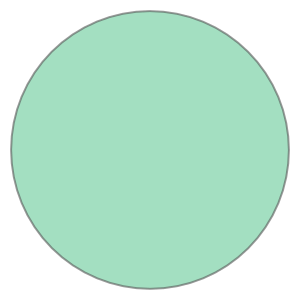

In [27]:
temp

In [20]:
type(temp)

shapely.geometry.polygon.Polygon

In [21]:
# match crs
# all_buffers = all_buffers.to_crs(meters_crs)
# bg_formodel = bg_formodel.to_crs(meters_crs)

# Spatial overlay operation to find only the areas that are in both geometries. 
# i.e. only the block group areas that are within any buffer zone
bg_inbuffer = gp.overlay(bg_formodel, all_buffers, how='intersection')

In [22]:
# Create new 'area' column for the areas of the intersections
bg_inbuffer = bg_inbuffer.to_crs(meters_crs)
bg_inbuffer['intersect_area'] = bg_inbuffer.area

NameError: name 'meters_crs' is not defined

In [ ]:
bg_inbuffer.sample(1)

In [ ]:
# Calculate the proportion of each block group within the buffer zone
#bg_inbuffer['intersect_prop'] = bg_inbuffer['intersect_area'] / bg_inbuffer.geometry.area

#bg_formodel = bg_formodel.set_index(bg_formodel.index.astype(int))
#bg_formodel = bg_formodel.reset_index().set_index('ID')

#bg_inbuffer = bg_inbuffer.set_index('ID')
#bg_formodel = bg_formodel.to_crs(meters_crs)
#bg_inbuffer['intersect_prop'] = bg_inbuffer['intersect_area'] / bg_formodel.loc[bg_inbuffer.index, 'geometry'].area


In [ ]:
bg_inbuffer['intersect_prop'] = bg_inbuffer['intersect_area'] / bg_inbuffer['Shape_Area']

In [ ]:
bg_inbuffer[['intersect_area', 'Shape_Area', 'intersect_prop']].sample(20)

In [ ]:
# # Apply the proportion to each demographic variable to find counts by variable
# demo_vars = ['ACSTOTPOP', 'UNDER5', 'OVER64', 'MINORPOP', 'LOWINCOME']
# for var in demo_vars:
#     bg_inbuffer[var + '_intersect_count'] = bg_inbuffer[var] * bg_inbuffer['intersect_prop']

# # find overall proportions for each demo var by dividing their count by their total population    
# for var in demo_vars:
#     bg_inbuffer[var + '_bg_totprop'] = bg_inbuffer[var] / bg_inbuffer['ACSTOTPOP']

In [ ]:
# It's not calculating correctly when a block group is completely contained within a buffer.
# so set the ceiling of possible proportions to 1. Band-aid fix. 
# Does this mean the area calculation is not right either?
#bg_flares['bg_5kbuf_prop'] = bg_flares['bg_5kbuf_prop'].clip(0, 1)

# calculate the outside-buffer proportion
#bg_flares['bg_5kbuf_out_prop'] = 1 - bg_flares['bg_5kbuf_prop']


    

### In/out buffer proportions

In [ ]:
# prop_vars = ['ACSTOTPOP_bg_totprop', 'UNDER5_bg_totprop', 'OVER64_bg_totprop', 'MINORPOP_bg_totprop', 'LOWINCOME_bg_totprop']
# in_buffer_prop = bg_inbuffer[prop_vars].mean()
# out_buffer_prop = 1-in_buffer_prop

# # create a table from the in-buffer and outside-buffer proportions
# proportions = pd.concat([in_buffer_prop, out_buffer_prop], axis=1)
# proportions.columns = ['In_Buffer', 'Outside_Buffer']

# # table that compares the in-buffer proportions to the outside-buffer proportions
# print(proportions)

### In/out buffer counts

In [ ]:
# count_vars = ['ACSTOTPOP_intersect_prop', 'UNDER5_intersect_prop', 'OVER64_intersect_prop', 'MINORPOP_intersect_prop', 'LOWINCOME_intersect_prop']

# in_buffer_tot = bg_inbuffer[count_vars].sum()
# out_buffer_tot = bg_formodel['ACSTOTPOP'].sum() - in_buffer_tot

# # create a table from the in-buffer and outside-buffer counts
# counts = pd.concat([in_buffer_tot, out_buffer_tot], axis=1)
# counts.columns = ['In_Buffer_Count', 'Outside_Buffer_Count']
# # format w thousands separators
# counts[['In_Buffer_Count', 'Outside_Buffer_Count']] = counts[['In_Buffer_Count', 'Outside_Buffer_Count']].applymap('{:,.0f}'.format)

# # table that compares the in-buffer counts to the outside-buffer counts
# print(counts)

## Visualization with Folium

In [ ]:
# Convert the GeoDataFrame to the same CRS as the folium map (if necessary)
bg_formodel = bg_formodel.to_crs(3857)

# Create a folium map with a center location
m = folium.Map(location=[38.377158,-121.645792], zoom_start=6, tiles=None,overlay=False)  #start w lat/long roughly in center of CA
base_map = folium.FeatureGroup(name='Base map', overlay=True, control=False)
folium.TileLayer(tiles='OpenStreetMap').add_to(base_map)
base_map.add_to(m)

In [ ]:
# Choropleth of Block Groups
folium.Choropleth(bg_formodel,
                  data=bg_formodel,
                  columns = ['ID', 'D_PM25_2'], 
                  key_on='feature.properties.ID',
                  fill_color="Reds",
                  fill_opacity=0.7,
                  line_opacity=0.2,
                  legend_name="PM2.5 Index",
                 name="Block Groups").add_to(m)

In [ ]:
# Feature Group: Buffers

def style_function(feature):
    return {
        'fillColor': 'red',
        'color': 'red',
        'fillOpacity': 0.2
    }

all_flares_buffers = folium.FeatureGroup(name='Flare Buffers', overlay=True)
folium.GeoJson(
    data=ca_flares["buffer_2000m"],
    style_function=style_function
).add_to(all_flares_buffers)
all_flares_buffers.add_to(m)

In [ ]:
# Feature Group: BG-Buffer Intersections

def style_function2(feature):
    return {
        'fillColor': 'blue',
        'color': 'blue',
        'fillOpacity': 0.2
    }

intersect = folium.FeatureGroup(name='BG-Flare Intersections', overlay=True)
folium.GeoJson(
    data=bg_inbuffer['geometry'],
    style_function=style_function2
).add_to(intersect)
intersect.add_to(m)

In [ ]:
# Add hover functionality
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#999999', 
                                'color':'#999999', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = bg_inbuffer,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['ID','CNTY_NAME', 'intersect_prop', 'intersect_area', 'Shape_Area', 'D_PM25_2', 'MINORPOP',],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)

In [ ]:
# add hover functionality as child to map, add layering, display map
m.add_child(NIL)
m.keep_in_front(NIL)
folium.LayerControl().add_to(m)
m

In [ ]:
# # Flares
# all_flares_points = folium.FeatureGroup(name='flare points', overlay=True)
# folium.GeoJson(data=ca_flares["geometry"]).add_to(all_flares_points)
# all_flares_points.add_to(m)